# Steam Data Analysis with Python

## Introduction

Most commonly-heard of games from big AAA developers, Stardew Valley stood out as a popular indie game, only one dev and 4 years. Critical and commercial success - over 10 million copies sold. How likely is this level of success? Is it rare for indie games to be successful? How many of top games are indie? How do ratings for indie games compare to AAA games? What genres are popular in gaming in general, and indie vs AAA?

Info collected via web scraping Steam, allowed by robot.txt. Data collected 2/10/20 (update this).

## Importing Libraries and Setting Up

Need selenium instead of requests library since Javascript.

In [328]:
from selenium import webdriver
import requests
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

Begin to scrape data. Data from Steam's top 100 games of 2017, 2018, 2019.

In [2]:
urls = {2017: 'https://store.steampowered.com/sale/2017_best_sellers/',
        2018: 'https://store.steampowered.com/sale/winter2018bestof/',
        2019: 'https://store.steampowered.com/sale/2019_top_sellers'}
lst = []

for i in range(2017, 2020):
    driver = webdriver.Chrome('C:\Chromedriver\chromedriver.exe')
    driver.get(urls[i])
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()
    time.sleep(1)
    
    columns = ['year', 'ranking', 'title', 'genres', 'tags', 'rating', 'num_reviews']
    year = i
    table = []
    
    divs = soup.find_all('div',\
                         attrs={'class': 'partnersaledisplay_SaleSection_1cOoC eventbbcodeparser_SaleSectionCtn_39HWX'})
    # Try and except statements necessary due to different HTML for different years
    if divs == []:
        divs = soup.find_all('div', attrs={'class': 'sale_tier'})
    for div in divs:
        try:
            ranking = div.find(attrs={'div', 'partnereventshared_SaleSectionHeader_2WMiQ'}).text
        except AttributeError:
            ranking = div.h2.text
            
        if ranking != '':
            games = div.find_all('a')
            for game in games:
                game_url = game['href']
                # Cookies necessary to bypass age verification
                source = requests.get(game_url, cookies={'birthtime': '691574401'}).content
                game_page = BeautifulSoup(source, 'html.parser')
                time.sleep(1)

                title = game_page.find('div', attrs={'class': 'apphub_AppName'}).text

                genres = []
                genre_links = game_page.find('div',\
                                        attrs={'class': 'block responsive_apppage_details_left game_details underlined_links'})\
                                       .find('div', attrs={'class': 'details_block'}).find_all('a')
                for genre_link in genre_links:
                    if 'genre' in str(genre_link):
                        genres.append(genre_link.string)

                tags = []
                tag_links = game_page.find('div', attrs={'class': 'glance_tags popular_tags'}).find_all('a')
                for tag_link in tag_links:
                    tags.append(tag_link.string.strip())

                try:
                    rating_num_reviews = game_page.find('div', attrs={'itemprop': 'aggregateRating'})\
                                                  .find('span',attrs={'class': 'nonresponsive_hidden responsive_reviewdesc'})\
                                                  .get_text('|')
                    rating_num_reviews_split = re.split('(\d+)', rating_num_reviews.strip().replace(',', ''))
                    rating = int(rating_num_reviews_split[1])
                    num_reviews = int(rating_num_reviews_split[3])
                except AttributeError:
                    rating = 0
                    num_reviews = 0

                row = [year, ranking, title, genres, tags, rating, num_reviews]
                table.append(row)
                
    lst.append(pd.DataFrame(table, columns=columns))
    
df = pd.concat(lst).reset_index(drop=True)

Now we have our data...

Should note that the ratings/num_reviews only represents their current value as of date of data collection, does not represent what they were in 2017, 2018, or 2019.

Determine what percent of top games are indie - must search for "Indie" in both genres and tags columns.

In [3]:
df['is_indie'] = df.apply(lambda row: True if ('Indie' in row['genres'] or 'Indie' in row['tags']) else False, axis=1)
df

,year,ranking,title,genres,tags,rating,num_reviews,is_indie
0,2017,Platinum,Rocket League®,"[Action, Indie, Racing, Sports]","[Multiplayer, Soccer, Competitive, Sports, Rac...",92,270980,True
1,2017,Platinum,ARK: Survival Evolved,"[Action, Adventure, Indie, Massively Multiplay...","[Open World Survival Craft, Survival, Open Wor...",74,220484,True
2,2017,Platinum,Tom Clancy's Ghost Recon® Wildlands,"[Action, Adventure]","[Open World, Shooter, Action, Co-op, Multiplay...",76,34310,False
3,2017,Platinum,Warframe,"[Action, Free to Play]","[Looter Shooter, Free to Play, Action, Co-op, ...",92,328571,False
4,2017,Platinum,Grand Theft Auto V,"[Action, Adventure]","[Open World, Action, Multiplayer, Automobile S...",78,649281,False
...,...,...,...,...,...,...,...,...
294,2019,Bronze,Terraria,"[Action, Adventure, Indie, RPG]","[Open World Survival Craft, Sandbox, Survival,...",97,318290,True
295,2019,Bronze,Paladins®,"[Action, Free to Play]","[Hero Shooter, Free to Play, Multiplayer, FPS,...",85,246004,False
296,2019,Bronze,American Truck Simulator,"[Indie, Simulation]","[Automobile Sim, Simulation, Driving, Open Wor...",94,34093,True
297,2019,Bronze,ASTRONEER,"[Adventure, Indie]","[Open World Survival Craft, Open World, Surviv...",88,45910,True


Now we will make a pie chart.

In [4]:
df.is_indie.value_counts().reset_index().rename(columns={'index': 'is_indie', 'is_indie': 'counts'})

,is_indie,counts
0,False,215
1,True,84


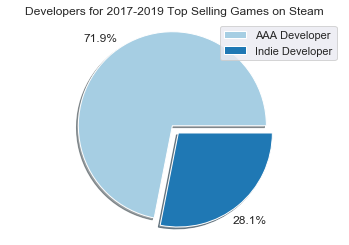

In [351]:
fig, ax = plt.subplots()
ax.pie(df.is_indie.value_counts(), autopct='%0.1f%%', pctdistance=1.2, shadow=True, explode=(0, 0.1))
ax.legend(['AAA Developer', 'Indie Developer'])
ax.set_title('Developers for 2017-2019 Top Selling Games on Steam')
ax.axis('equal')
plt.show()

Indie games cover 28.1% of the market, actually not that rare!

Now compare indie ratings to AAA ratings.

In [6]:
df.groupby('is_indie').rating.mean().reset_index()

,is_indie,rating
0,False,80.079070
1,True,89.833333


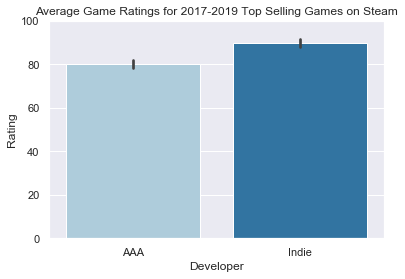

In [352]:
fig, ax = plt.subplots()
sns.barplot(data=df, x='is_indie', y='rating')
ax.set_xlabel('Developer')
ax.set_xticklabels(['AAA', 'Indie'])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_ylabel('Rating')
ax.set_title('Average Game Ratings for 2017-2019 Top Selling Games on Steam')
plt.show()

Indie games are rated almost a full 10% higher than AAA games on average!

Now compare indie genre ratings to other genre ratings. Genres with counts lower than 10 are dropped in our genre analysis to avoid skewing the data with possible outliers.

In [8]:
genre_counts = df.explode('genres').groupby('genres').title.count().reset_index().rename(columns={'title': 'counts'})
genre_ratings = df.explode('genres').groupby('genres').rating.mean().reset_index()

genre_counts_ratings = pd.merge(genre_counts, genre_ratings).sort_values(by='rating', ascending=False)
genre_counts_ratings = genre_counts_ratings[genre_counts_ratings.counts >= 10].reset_index(drop=True)
genre_counts_ratings

,genres,counts,rating
0,Indie,68,91.132353
1,Early Access,10,90.100000
2,Strategy,82,84.219512
3,Free to Play,34,83.882353
4,RPG,82,83.707317
5,Simulation,91,83.076923
6,Action,174,81.890805
7,Adventure,94,81.436170
8,Massively Multiplayer,36,75.111111
9,Sports,15,64.666667


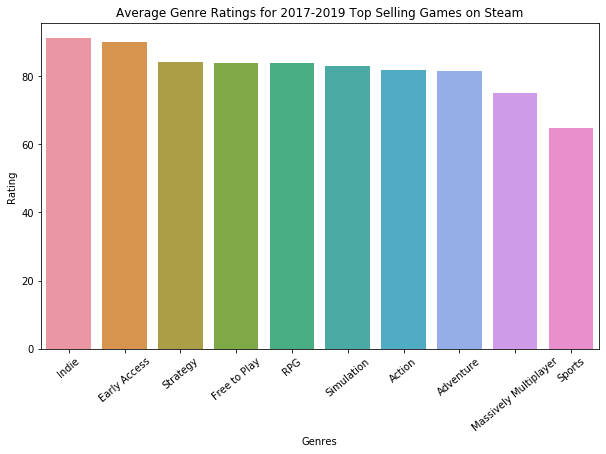

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette('husl')
sns.barplot(data=genre_counts_ratings, x='genres', y='rating')
plt.xticks(rotation=40)
ax.set_xlabel('Genres')
ax.set_ylabel('Rating')
ax.set_title('Average Genre Ratings for 2017-2019 Top Selling Games on Steam')
plt.show()

In [10]:
print("The average genre rating is: {0}".format(genre_counts_ratings.rating.mean()))

The average genre rating is: 81.92232108158136


The "Indie" genre is the highest, with an amazing average rating of 91.1, which is almost 10 points higher than the average of 81.9.

We now know that indie games can be successful, and are rated on average much better than AAA developer games or other genres, are they becoming more popular and increasing their hold on the market?

In [11]:
indie_counts = df.groupby(['year', 'is_indie']).title.count().reset_index().rename(columns={'title': 'counts'})
year_counts = df.groupby('year').title.count().reset_index().rename(columns={'title': 'year_counts'})
indie_year_counts = pd.merge(indie_counts, year_counts)
indie_year_counts['percentage'] = indie_year_counts.counts / indie_year_counts.year_counts
indie_year_counts

,year,is_indie,counts,year_counts,percentage
0,2017,False,71,99,0.717172
1,2017,True,28,99,0.282828
2,2018,False,73,100,0.730000
3,2018,True,27,100,0.270000
4,2019,False,71,100,0.710000
5,2019,True,29,100,0.290000


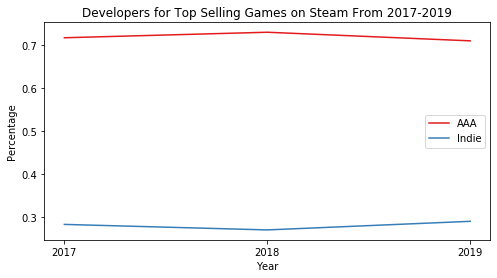

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_palette('Set1')
sns.lineplot(data=indie_year_counts, x='year', y='percentage', hue='is_indie')
ax.set_xticks([2017, 2018, 2019])
ax.legend(['AAA', 'Indie'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Developers for Top Selling Games on Steam From 2017-2019')
plt.show()

Doesn't look like much has changed, let's run a chi squared test to check.

In [13]:
X = [[71, 28],
     [73, 27],
     [71, 29]]

chi2, pval, dof, expected = stats.chi2_contingency(X)
print("The p-value is {0}".format(pval))

The p-value is 0.9504560943428806


With a p-value of 0.95, we cannot reject the null hypothesis that there is no significant difference between the datasets.

Does not appear that more indie games are increasing their hold on the top 100 selling games on Steam. Could a reason be because they make less than AAA games? Maybe not since that should be expected, but let's see.

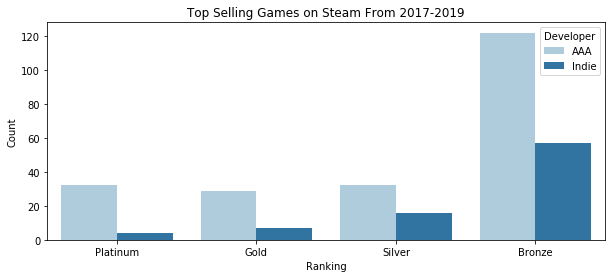

In [103]:
indie_games = df[df.is_indie == True]
AAA_games = df[df.is_indie == False]

fig, ax = plt.subplots(figsize=(10, 4))
sns.set_palette('Paired')
sns.barplot(data=df, x='ranking', y='rating', hue='is_indie', estimator=len)
ax.set_xlabel('Ranking')
ax.set_ylabel('Count')
ax.set_title('Top Selling Games on Steam From 2017-2019')
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['AAA', 'Indie'], title="Developer")
plt.show()

Indie games make up a very small portion of top tier games ("Platinum" and "Gold") and thus generally make less than their AAA counterparts. However this makes sense due to the lower financial support they receive.

Lastly, let's see if indie developers focus on different genres than AAA developers. ("Indie" genre exluded from analysis)

In [343]:
genre_explode = df.explode('genres')
genre_explode_no_indie = genre_explode[genre_explode.genres != 'Indie']
dev_genre_counts = genre_explode_no_indie.groupby(['is_indie', 'genres']).title.count().reset_index()\
                                         .rename(columns={'title': 'counts'})\
                                         .sort_values(by=['is_indie', 'counts'], ascending=[True, False])
AAA_genre_counts = dev_genre_counts[dev_genre_counts.is_indie == False]
indie_genre_counts = dev_genre_counts[dev_genre_counts.is_indie == True]
dev_genre_counts

,is_indie,genres,counts
0,False,Action,134
9,False,Strategy,64
7,False,Simulation,59
5,False,RPG,56
1,False,Adventure,54
3,False,Free to Play,31
4,False,Massively Multiplayer,25
8,False,Sports,12
2,False,Casual,1
6,False,Racing,1


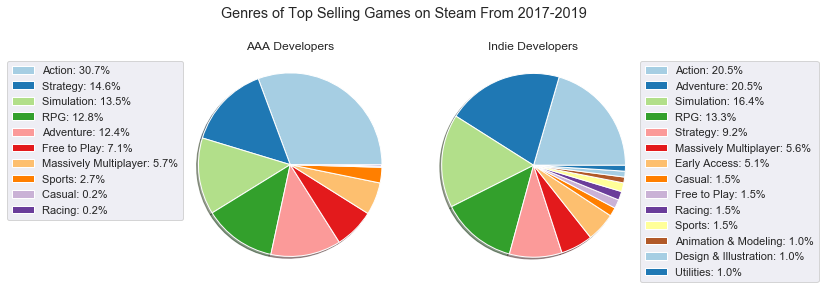

In [349]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Genres of Top Selling Games on Steam From 2017-2019', y=1.05)

percentage1 = 100 * np.array(AAA_genre_counts.counts) / sum(np.array(AAA_genre_counts.counts))
label1 = ['{0}: {1:0.1f}%'.format(a, b) for (a, b) in zip(AAA_genre_counts.genres, percentage1)]
ax1.pie(AAA_genre_counts.counts, shadow=True)
ax1.legend(label1, bbox_to_anchor=(0, 1))
ax1.set_title('AAA Developers')
ax1.axis('equal')

percentage2 = 100 * np.array(indie_genre_counts.counts) / sum(np.array(indie_genre_counts.counts))
label2 = ['{0}: {1:0.1f}%'.format(a, b) for (a, b) in zip(indie_genre_counts.genres, percentage2)]
ax2.pie(indie_genre_counts.counts, shadow=True)
ax2.legend(label2, bbox_to_anchor=(1, 1))
ax2.set_title('Indie Developers')
ax2.axis('equal')

plt.show()